In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import time

In [2]:
#variables:

L = 3 #metre, longueur du mur
n = 72 #nombre de carrés
dx = L/n #pas de distance 
kappa = 2e-5 #m^2/s, le coefficient de diffusion
T_rad = 70 #°C, température du radiateur 
T_ext = 0 #°C, tempérautre extérieure

Lambda = 0.025 #conductivité thermique de l'air (entre 0.024 et 0.026)
F = 0.1 #le nombre de Courant 

dt = F*dx**2/kappa #voir calcule ci-dessous
jours = 20
temps_tot = jours * 24 * 3600 #durée totale de l'expérience en seconde
n_etapes = ceil(temps_tot/dt) #nombre d'étapes de longueur dt durant le temps totale. ceil prends le nombre entier arondi vers le haut (plafond) 
print(f"Temps total = {temps_tot:.0f} s, pas dt = {dt:.3f} s, étapes ≈ {n_etapes}")

#position de la fenetre et du radiateur:

fen_ligne = np.arange(30,60)
fen_col = np.array([0])

rad_ligne = np.arange(4, 18)
rad_col = np.arange(8, 12)


Temps total = 1728000 s, pas dt = 8.681 s, étapes ≈ 199066


$$F = \frac{\Delta t}{\Delta X^2}\kappa$$
$$\Delta t = \frac{F \cdot \Delta X^2}  {\kappa}$$

In [3]:
def cond_bord(T):
    """ Applique les conditions de bord sur la matrice T de température
    INPUT: T, matrice (n,n) des températures
    OUTPUT: T modifiée avec conditions de bord
    """
    T[fen_ligne, fen_col]=T_ext #température de la fenetre et du radiateur constants
    T[np.ix_(rad_ligne, rad_col)]=T_rad

    #on veut que la dérivé partielle de la température par rapport à la position soit =0 
    #alors on veut que la pente soit nulle-> on dit que la température derrière le mur et la température de l'avant dernière case sont égaux, mise apart la fenetre.

    #mure de gauche a une complication, à cause de la fenêtre:
    mur_gauche = np.ones(n, dtype=bool)# dtype=bool permet de dire True or False 
    mur_gauche[fen_ligne] = False
    T[mur_gauche, 0] = T[mur_gauche, 1]#la température du mur et la température proche du mur sont de la même température dT/dy = 0

    #mur droite
    T[:,-1] = T[:,-2]

    #plafond
    T[-1,:]=T[-2,:]

    #sol
    T[0,:]=T[1,:]
    
T_initiale = np.ones((n,n))*T_ext
cond_bord(T_initiale)
T = T_initiale

def etape_1(T):
    """ Calcule une étape de temps dt de l'évolution de la température
    INPUT: T, matrice (n,n) des températures à l'instant n*dt
    OUTPUT: T_nplus1, matrice (n,n) des températures à l'instant (n+1)*dt
    """
    #chaque carré a 4 voisins (sauf au bords), donc i et j pour x et y et p et m pour plus et moins (p.ex im, jp = i-1,j+1)
    T_ip = np.empty_like(T)#np.empty_like permet de faire un tableau de meme forme et de meme type que T
    T_im = np.empty_like(T)
    T_jp = np.empty_like(T)
    T_jm = np.empty_like(T)

    T_ip[:, :-1] = T[:, 1:] #pour toute les lignes. (:-1)Du début jusqu'à l'avant dernière ligne, (1:)de la deuxième ligne jusqu'à la fin. 
    T_ip[:, -1] = T[:, -1]  # bord, pour ne pas avoir une dernière colonne aléatoire (n'est pas la condition de bord écrite avant)
    T_im[:, 1:] = T[:, :-1] #même chose que T_ip mais de droite à gauche cette fois
    T_im[:, 0] = T[:, 0] #premiere colonne n'est pas random
    T_jp[:-1, :] = T[1:, :] #les quatres prochaines lignes de codes sont les même que les les quatres d'avant mais cette fois on monte et on descend.
    T_jp[-1, :] = T[-1, :]
    T_jm[1:, :] = T[:-1, :]
    T_jm[0, :] = T[0, :]

    T_nplus1 = T + dt/(dx**2) * kappa*(T_jp+T_ip -4*T+T_im+T_jm)
    return T_nplus1



def densite_de_courant(T):
    """ Calcule du flux thermique traversant la fenêtre et le radiateur
    INPUT: T, matrice (n,n) des températures à l'instant n*dt
    OUTPUT: integral_fen, flux thermique traversant la fenêtre (W/m)
            integral_rad, flux thermique traversant le radiateur (W/m)
    """
    #la formule donnée est la suivante : j = -lambda n * nabla T
    #pour la fenetre le grandient pointe vers l'extérieure de la pièce(vers la gauche).
    #le gradient dans cette direction = (T(x=0)-T(x=dx))/dx

    j_fen =       - Lambda * (T_ext-T[fen_ligne,   1])/dx #droite
    #j_fen_haut =  - Lambda * (T_ext-T[fen_ligne+1, 0])/dx 
    #j_fen_coinh = - Lambda * (T_ext-T[fen_ligne+1, 1])/ np.sqrt(dx**2+dx**2) #coin haut droite
    #j_fen_bas =   - Lambda * (T_ext-T[fen_ligne-1, 0])/dx
    #j_fen_coinb = - Lambda * (T_ext-T[fen_ligne-1, 1])/ np.sqrt(dx**2+dx**2)  #coin bas droite

    #j_fen =       - Lambda * (T[fen_ligne, 1]-T[fen_ligne,   2])/dx #droite
    #j_fen_haut =  - Lambda * (T[fen_ligne+1,0]-T[fen_ligne+2, 0])/dx 
    #j_fen_coinh = - Lambda * (T_ext-T[fen_ligne+1, 1])/ np.sqrt(dx**2+dx**2) #coin haut droite
    #j_fen_bas =   - Lambda * (T[fen_ligne-1,0]-T[fen_ligne-2, 0])/dx
    #j_fen_coinb = - Lambda * (T_ext-T[fen_ligne-1, 1])/ np.sqrt(dx**2+dx**2)  #coin bas droite


    integral_fen = np.sum(j_fen)*dx #+np.sum(j_fen_haut)*dx +np.sum(j_fen_bas)*dx#+np.sum(j_fen_coinh)*dx+np.sum(j_fen_coinb)*dx

    #pour le radiateur, c'est un peu différent comme il n'est pas contre le mur
    #T[rad_ligne, rad_col]=T_rad
    #cote gauche  
    #j_gauche = -Lambda *(T[rad_ligne, rad_col[0]]-T[rad_ligne, rad_col[0]-1])/dx #température du radiateur moins température juste en dehors 
    #j_droite = Lambda *(T[rad_ligne, rad_col[-1]]-T[rad_ligne, rad_col[-1]+1])/dx
    #j_bas = -Lambda *(T[rad_ligne[0], rad_col]-T[rad_ligne[0]-1, rad_col])/dx
    #j_haut = Lambda *(T[rad_ligne[-1], rad_col]-T[rad_ligne[-1]+1, rad_col])/dx
    
    #ca marche bien ca:
    j_gauche = -Lambda *(T[rad_ligne,       rad_col[0]-1] -T_rad)/dx #température du radiateur moins température juste en dehors 
    j_droite = -Lambda *(T[rad_ligne,       rad_col[-1]+1]-T_rad)/dx
    j_bas =    -Lambda *(T[rad_ligne[0]-1,  rad_col]      -T_rad)/dx
    j_haut =   -Lambda *(T[rad_ligne[-1]+1, rad_col]      -T_rad)/dx

    #j_coinhd = -Lambda *(T[19,13]                         -T_rad)/np.sqrt(dx**2+dx**2) 
    #j_coinhg = -Lambda *(T[19,7]                          -T_rad)/np.sqrt(dx**2+dx**2) 
    #j_coinbd = -Lambda *(T[3,13]                          -T_rad)/np.sqrt(dx**2+dx**2) 
    #j_coinbg = -Lambda *(T[3,7]                           -T_rad)/np.sqrt(dx**2+dx**2) 

    #j_gauche = -Lambda *(T[rad_ligne, rad_col[0]-2]-T[rad_ligne, rad_col[0]-1])/dx #température du radiateur moins température juste en dehors 
    #j_droite = -Lambda *(T[rad_ligne, rad_col[-1]+2]-T[rad_ligne, rad_col[-1]+1])/dx
    #j_bas = -Lambda *(T[rad_ligne[0]-2, rad_col]-T[rad_ligne[0]-1, rad_col])/dx
    #j_haut = -Lambda *(T[rad_ligne[-1]+2, rad_col]-T[rad_ligne[-1]+1, rad_col])/dx


    integral_rad = np.sum(j_gauche)*dx + np.sum(j_droite)*dx + np.sum(j_bas)*dx + np.sum(j_haut)*dx#+ np.sum(j_coinhd)*dx+ np.sum(j_coinhg)*dx+ np.sum(j_coinbd)*dx+ np.sum(j_coinbg)*dx
    return integral_fen, integral_rad


[0.00000e+00 4.00000e+02 8.00000e+02 1.20000e+03 1.60000e+03 2.00000e+03
 2.40000e+03 2.80000e+03 3.20000e+03 3.60000e+03 1.18800e+04 2.11950e+04
 3.05100e+04 3.98250e+04 4.91400e+04 5.84550e+04 6.77700e+04 7.70850e+04
 8.64000e+04 2.50560e+05 4.35240e+05 6.19920e+05 8.04600e+05 9.89280e+05
 1.17396e+06 1.35864e+06 1.54332e+06 1.72800e+06]
[0, 46, 92, 138, 184, 230, 276, 322, 368, 414, 1368, 2441, 3514, 4587, 5660, 6734, 7807, 8880, 9953, 28864, 50139, 71414, 92689, 113965, 135240, 156515, 177790, 199065]


/var/folders/t8/25_z914s7rq8586gnl7rnj480000gn/T/ipykernel_42937/1689052635.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


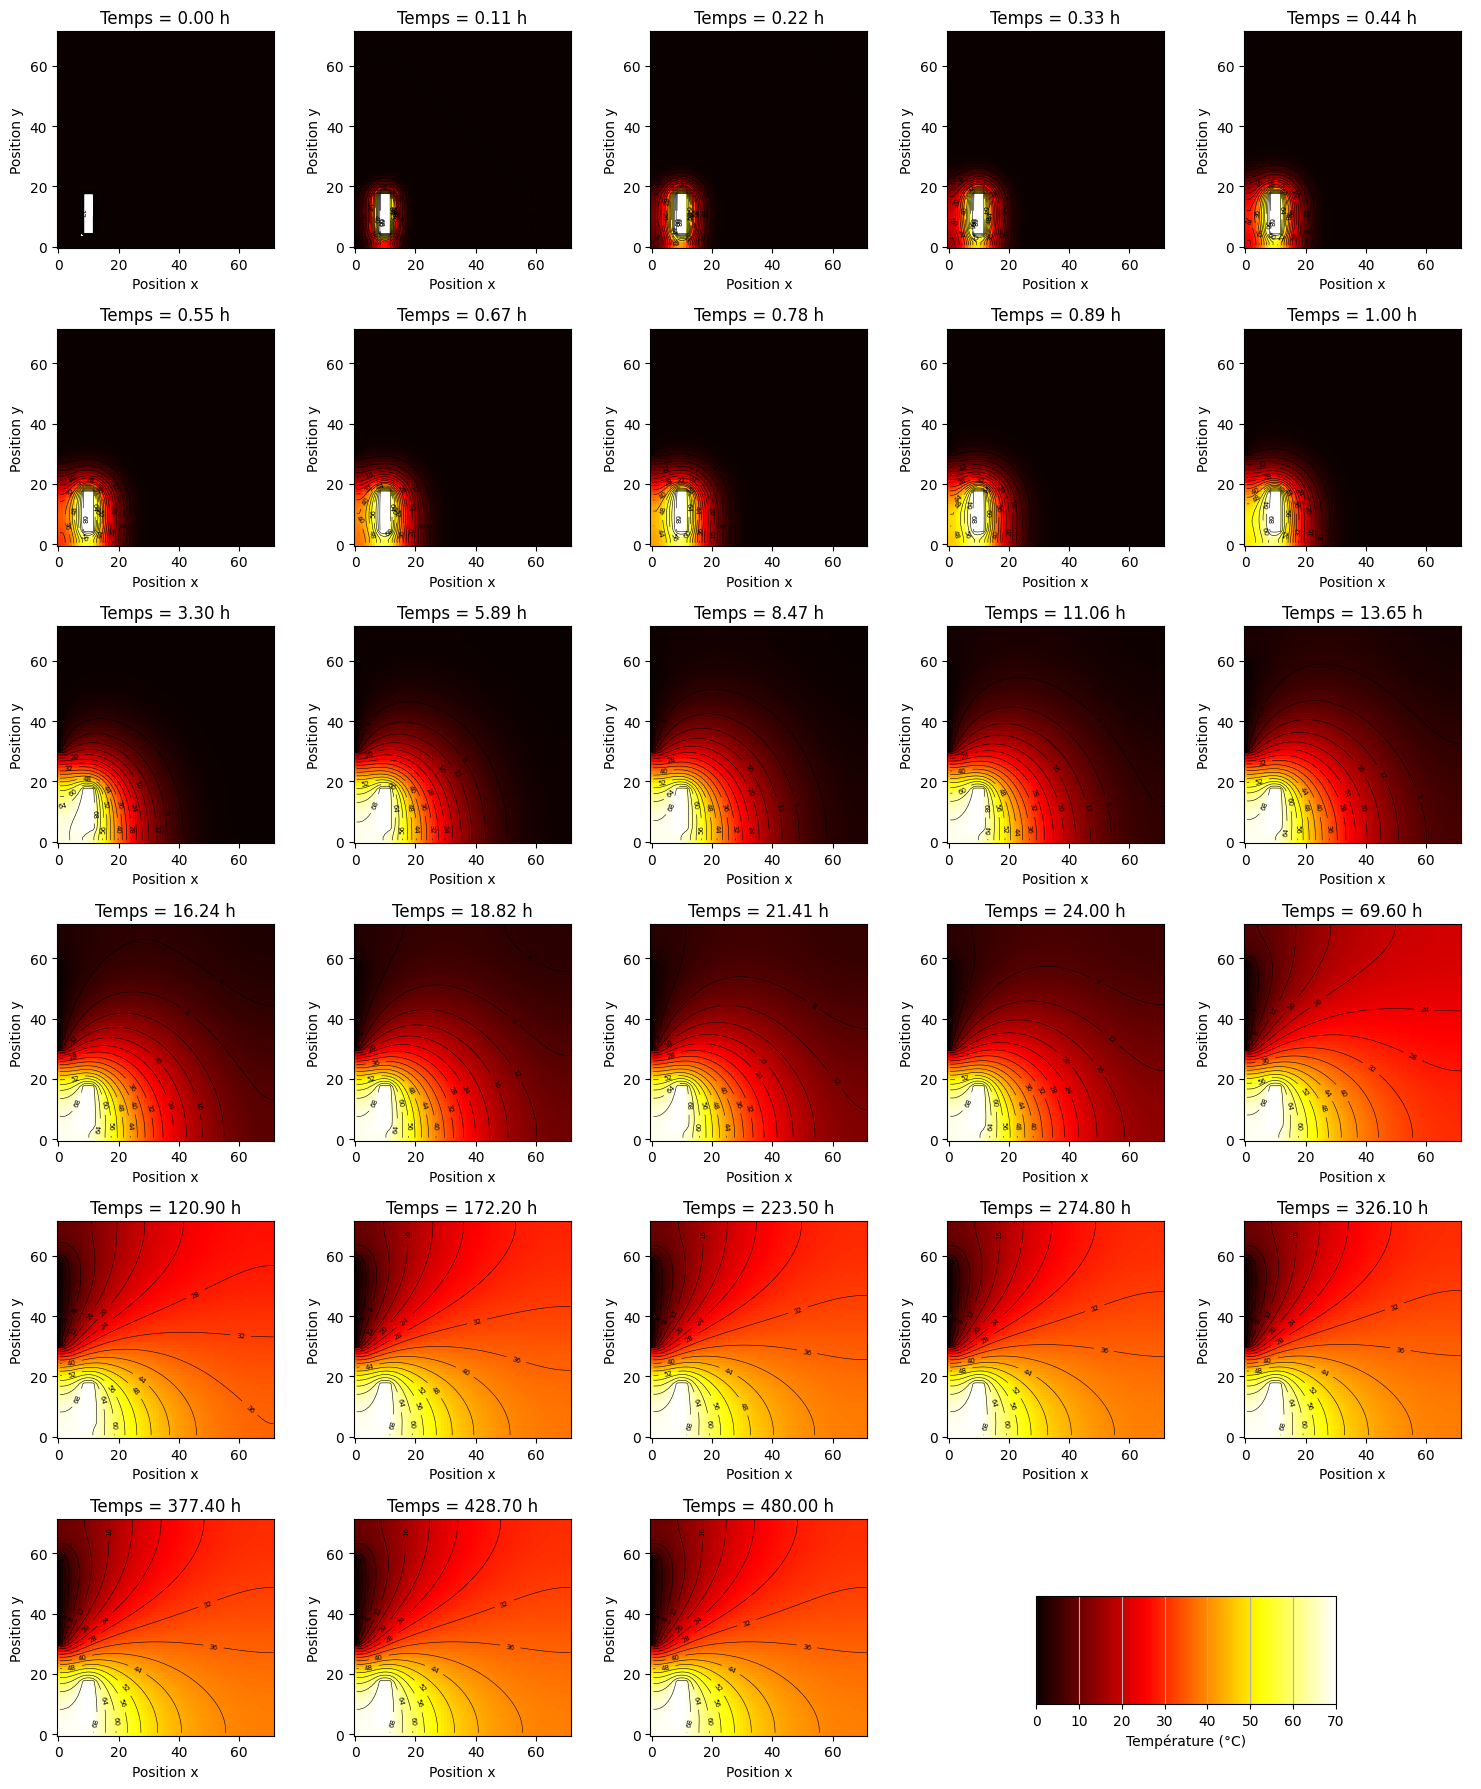

Text(0.5, 1.0, 'Évolution temporelle du flux thermique Zoom')

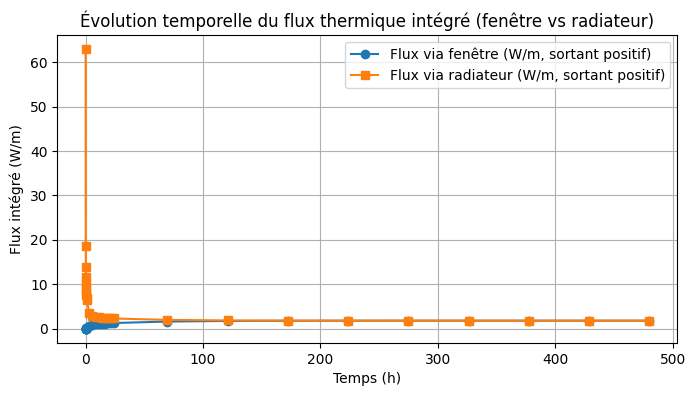

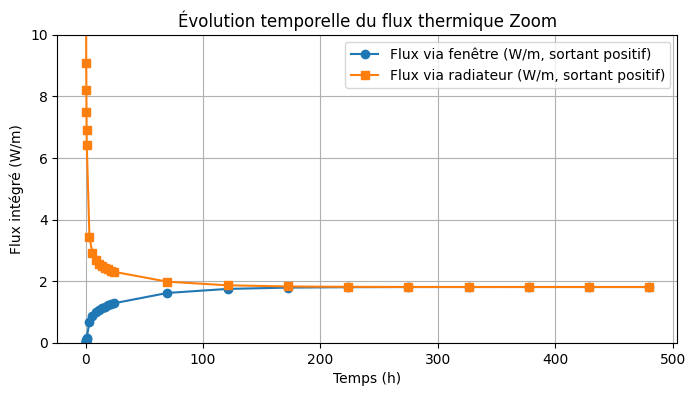

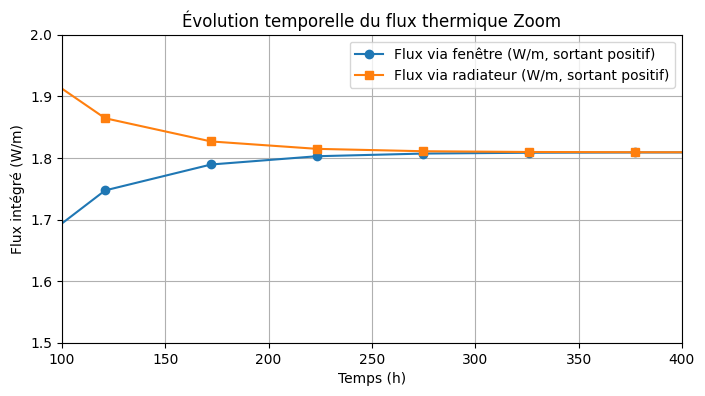

In [4]:
#définitions:

#on veut prendre une dixaine de snapshots durant la première heure,
#dix durant la première journée et 10 sur la totalité du temps simulé

snapshot_hour = np.linspace(0,3600,10)
snapshot_day = np.linspace(11880, 24*3600, 9)#9 pour ne pas faire celui de 24h deux fois 
snapshot_totalite = np.linspace(250560, 20*24*3600, 9)

snaps = np.hstack((snapshot_hour, snapshot_day, snapshot_totalite))#on mets les 3 arrays en un

snap_ind = [int(t/dt) for t in snaps]# a quel step on prend le snapshot, index
print(snaps)
print(snap_ind)

snapshots = [] #listes vide pour storer les informations plus tard, "photos" des matrices de températures à différents temps
snapshot_temps = [] #Les différents temps associés aux snapshots
courant_fen = [] #Les flux thermiques à travers la fenêtre
courant_rad = [] #Les flux thermiques à travers le radiateur

snap_i = 0 
for etape in range(n_etapes+1):#range va continuer la boucle jusqu'au stop n_etapes+1
    #début de la boucle, on veut sauvegarder les snaps qu'on a définit avant, et les listes
    if etape in snap_ind: #pour les étapes qui sont comprise dans snap_ind
        temps = etape * dt
        snapshots.append(T.copy()) #append ne change pas la liste mais ajoute seulement à la fin de la liste la valeur en question
        snapshot_temps.append(temps)
        cour_fen, cour_rad = densite_de_courant(T)
        courant_fen.append(cour_fen)
        courant_rad.append(cour_rad)
        snap_i += 1
        if snap_i >= len(snap_ind): #dès qu'on a toute nos mesures, les trentes mesures on s'arrete
            break 
    cond_bord(T) #on applique les cond de bord avant pour que le calcule soit corrrect
    T=etape_1(T)
    cond_bord(T)# on re-applique les cond de bord pour remmettres les bord au bonne valeurs



#Figures:
n_snaps = len(snapshots)
n_cols = 5
n_rows = ceil(n_snaps / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3*n_rows))

for i, ax in enumerate(axes.flat):
    if i < n_snaps:

        # Image thermique
        im = ax.imshow(
            snapshots[i],
            cmap='hot',
            vmin=T_ext,
            vmax=T_rad,
            origin='lower'
        )

        # Contours (courbes de niveau)
        cs = ax.contour(
            snapshots[i],
            levels=20,
            colors='black',
            linewidths=0.4,
            origin='lower'
        )
        ax.clabel(cs, inline=True, fontsize=5)

        ax.set_title(f'Temps = {snapshot_temps[i]/3600:.2f} h')
        ax.set_xlabel('Position x')
        ax.set_ylabel('Position y')
    else:
        ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.70, 0.05, 0.2, 0.06]), ax=axes.ravel().tolist(), shrink=0.5, label='Température (°C)', location='bottom')
plt.tight_layout()
plt.grid(True)
plt.show()


fig2, ax2 = plt.subplots(figsize=(8,4))
times_hours = np.array(snaps)/3600.0
ax2.plot(times_hours, courant_fen, marker='o', label='Flux via fenêtre (W/m, sortant positif)')
ax2.plot(times_hours, courant_rad, marker='s', label='Flux via radiateur (W/m, sortant positif)')
ax2.set_xlabel("Temps (h)")
ax2.set_ylabel("Flux intégré (W/m)")
ax2.legend()
ax2.grid(True)
ax2.set_title("Évolution temporelle du flux thermique intégré (fenêtre vs radiateur)")

fig3, ax3 = plt.subplots(figsize=(8,4))
times_hours = np.array(snaps)/3600.0
ax3.plot(times_hours, courant_fen, marker='o', label='Flux via fenêtre (W/m, sortant positif)')
ax3.plot(times_hours, courant_rad, marker='s', label='Flux via radiateur (W/m, sortant positif)')
ax3.set_xlabel("Temps (h)")
ax3.set_ylabel("Flux intégré (W/m)")
ax3.set_ylim(0,10)
ax3.legend()
ax3.grid(True)
ax3.set_title("Évolution temporelle du flux thermique Zoom")

fig4, ax4 = plt.subplots(figsize=(8,4))
times_hours = np.array(snaps)/3600.0
ax4.plot(times_hours, courant_fen, marker='o', label='Flux via fenêtre (W/m, sortant positif)')
ax4.plot(times_hours, courant_rad, marker='s', label='Flux via radiateur (W/m, sortant positif)')
ax4.set_xlabel("Temps (h)")
ax4.set_ylabel("Flux intégré (W/m)")
ax4.set_ylim(1.5,2)
ax4.set_xlim(100,400)
ax4.legend()
ax4.grid(True)
ax4.set_title("Évolution temporelle du flux thermique Zoom")

# Discussion

Le premier graph, avec les 28 images, démontre correctement comment la température change dans la chambre. Il y'en a 28 et non 30 parce que il devrait en avoir deux à 1h et deux à 24h. Les courbes de niveaux nous permettent de voir facilement quand on atteint l'équilibre car elles s'arrêtent de changer apres la "photo" de 120h. A partir de là chaque graph sont les mêmes, presque comme des copié collé (c'est ce qu'on attendais). 

Le deuxième graph et les zoom font du sense aussi. Le radiateur dégage énormément d'énergie au tout début car toute la chambre est a 0 degré et c'est là qu'il est le plus efficace. La fenêtre est à 0 au début car la chambre est encore froide et il n'y a donc pas d'échange de chaleur. Plus la pièce se réchauffe, moins le radiateur est efficace et plus la fenêtre transmet de la froideur vers la pièce. Les courbes suivent un sens logique et vont vers la même valeure avec le temps. Ceci fait du sens car, à l'équilibre, on peut s'attendre que la fenêtre et le radiateur transmettent la même chaleur vers la pièce. Dans le graph qui est le plus zoomé (le dernier graph) on peut observer que les valeurs se rejoignent plus exactement après l'heure 300. Si on retourne sur le premier graph et qu'on regarde de très près, les graphes pour les heures juste après 150 ne sont pas exactement les même, il y a un tout léger décalage des courbes de niveau qui peut être remarqué sur les bords. Le décalage en question est minime, tout comme la différence entre les courbes des flux. 

D'un point de vu numérique, je pense que ca fait du sense de prendre la version que j'ai décidé de prendre à la fin car le graph des flux est le meilleur dans ce cas 